In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from google.cloud import bigquery
from pandas import Timestamp
import pickle
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf

In [2]:
client = bigquery.Client.from_service_account_json("C:/Users/User/AirQo-d982995f6dd8.json")

In [7]:
#array with channel ids and coordinates
channels = [{'id':930434, 'lat':0.360209, 'long':32.610756},
            {'id':718028, 'lat':0.3075, 'long':32.6206}, 
            {'id':912224, 'lat':0.34646, 'long':32.70328}, 
            {'id':930426, 'lat':0.3655, 'long':32.6468}, 
            {'id':930427, 'lat':0.2689, 'long':32.588}, 
            {'id':912223, 'lat':0.341674, 'long':32.635306},
            {'id':912222, 'lat':0.325346, 'long':32.632288}, 
            {'id':912220, 'lat':0.322108, 'long':32.576}, 
            {'id':870145, 'lat':0.373078, 'long':32.628226}, 
            {'id':870143, 'lat':0.381576, 'long':32.647109},
            {'id':870144, 'lat':0.30778, 'long':32.651449}, 
            {'id':870147, 'lat':0.363, 'long':32.529}, 
            {'id':870142, 'lat':0.3759, 'long':32.528}, 
            {'id':870139, 'lat':0.3101, 'long':32.516}, 
            {'id':832255, 'lat':0.3875, 'long':32.601},
            {'id':832252, 'lat':0.2182, 'long':32.6176}, 
            {'id':832253, 'lat':0.269993, 'long':32.558017}, 
            {'id':832254, 'lat':0.3564, 'long':32.573}, 
            {'id':832251, 'lat':0.299, 'long':32.592}, 
            {'id':782720, 'lat':0.3517, 'long':32.591},
            {'id':782719, 'lat':0.29875, 'long':32.615}, 
            {'id':782718, 'lat':0.344, 'long':32.553}, 
            {'id':755614, 'lat':0.3412, 'long':32.602}, 
            {'id':755612, 'lat':0.289, 'long':32.589},
            {'id':870146, 'lat':0.3323, 'long':32.5698},
            {'id':737276, 'lat':0.295314, 'long':32.553682}, 
            {'id':737273, 'lat':0.354825, 'long':32.67781}, 
            {'id':689761, 'lat':0.314, 'long':32.59},
            {'id':718029, 'lat':0.059604, 'long':32.46032},
            {'id':718030, 'lat':0.347014, 'long':32.64936},
            {'id':730014, 'lat':0.235668, 'long':32.55764},
            {'id':782721, 'lat':0.2336, 'long':32.5635},
            {'id':782722, 'lat':0.2836, 'long':32.6},
            {'id':912219, 'lat':0.391478, 'long':32.62583},
            {'id':912221, 'lat':0.32232, 'long':32.5757},
            {'id':912225, 'lat':0.286595, 'long':32.506107},
            {'id':930429, 'lat': 0.307489, 'long':32.611755}
            ]

#### Functions to be used

In [8]:
def preprocessing(df): #hasn't yet been tested
    '''
    Preprocesses data for a particular channel
    '''
    df = df.sort_values(by='created_at',ascending=False)
    df = df.set_index('created_at')
    hourly_df = df.resample('H').mean()
    hourly_df.dropna(inplace=True)
    hourly_df= hourly_df.reset_index()
    return hourly_df

In [9]:
def get_entries_since(channel_id,daysago=7):
    '''
    Returns hourly data for the past 7 days for a particular channel
    '''
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    return df

#### Creating the dataset

In [111]:
#Arrays to hold X and Y data
X = np.zeros([0,3])
Y = np.zeros([0,1])

In [139]:
#get data for each channel and append it to X and Y arrays respectively
for channel in channels:
    d = get_entries_since(channel['id'])
    if d.shape[0]!=0:
        d = preprocessing(d)
        df = pd.DataFrame({'channel_id':[channel['id']], 
                           'longitude':[channel['long']], 
                           'latitude':[channel['lat']], 
                          })
        
        Xchan = np.c_[np.repeat(np.array(df)[:,1:],d.shape[0],0),[n.timestamp()/3600 for n in d['created_at']]]
        Ychan = np.array(d['pm2_5'])
        X = np.r_[X,Xchan]#appending device X data to array X
        Y = np.r_[Y,Ychan[:, None]]#appending device Y data to array Y
        print (str(channel['id'])+':done!')
    else:
        print(str(channel['id'])+':empty!')

930434:done!
718028:done!
912224:done!
930426:done!
930427:done!
912223:done!
912222:empty!
912220:done!
870145:done!
870143:done!
870144:done!
870147:done!
870142:done!
870139:done!
832255:empty!
832252:done!
832253:done!
832254:done!
832251:done!
782720:done!
782719:done!
782718:done!
755614:done!
755612:done!
870146:done!
737276:done!


KeyboardInterrupt: 

In [ ]:
import pickle
pickle.dump({'X':X,'Y':Y},open('kampala_23_09_20.p','wb'))

#### Start from here

In [140]:
import pickle
d = pickle.load(open('kampala_23_09_20.p','rb'))
X = d['X']
Y = d['Y']

In [141]:
X.shape

(4896, 3)

In [142]:
X[0,:]

array([3.2610756e+01, 3.6020900e-01, 4.4451800e+05])

In [143]:
kampala_locations  = pd.DataFrame(channels)
kampala_locations.head()

,id,lat,long
0,930434,0.360209,32.610756
1,718028,0.307500,32.620600
2,912224,0.346460,32.703280
3,930426,0.365500,32.646800
4,930427,0.268900,32.588000


In [144]:
#Visualizing locations
import folium
from branca.element import Figure

fig=Figure(width=550,height=350)
kampala_map=folium.Map(width=550,height=350,location=[0.3476, 32.5825],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(kampala_map)

for index, row in kampala_locations.iterrows():
    label = str(row['lat'])+','+str(row['long'])
    folium.Marker(location=[row['lat'], row['long']],popup=label,tooltip=label).add_to(kampala_map)
kampala_map

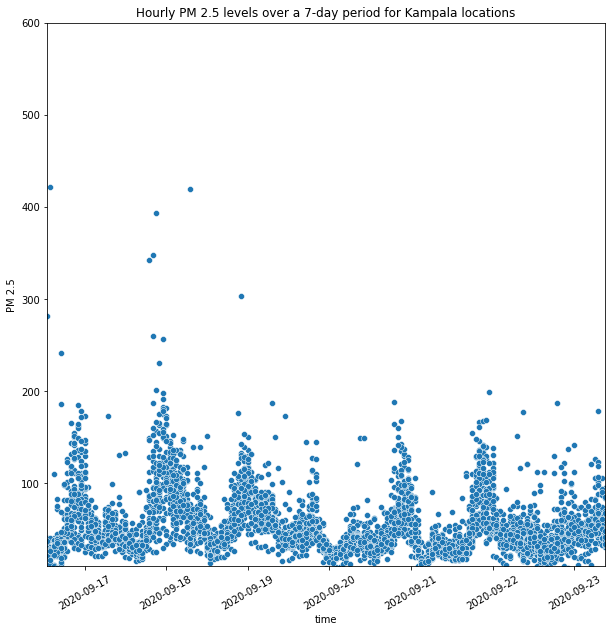

In [145]:
#Plotting PM levels over time
df1 = pd.DataFrame(X, columns = ['longitude', 'latitude', 'created_at'])
df2 = pd.DataFrame(Y, columns = ['PM 2.5'])
df = pd.concat([df1, df2], axis=1)

def generate_time(row):
    from pandas import Timestamp
    return Timestamp.fromtimestamp(row['created_at']*3600)
    
df['time'] = df.apply(lambda row: generate_time(row), axis=1)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x="time", y="PM 2.5", data=df);
plt.xlim(df['time'].min(), df['time'].max())
plt.ylim(10, 600)
plt.title('Hourly PM 2.5 levels over a 7-day period for Kampala locations')
plt.gca().xaxis.set_tick_params(rotation = 30)  
plt.savefig('kampala_pm_over_time_all.png')
plt.show()

#### Creating training set

In [146]:
#ounting the number of zeros in the array
np.count_nonzero(Y==0)

0

In [147]:
Y.shape

(4896, 1)

In [148]:
#Replacing zeros with NaNs
Yset = Y
Yset[Yset==0] = np.nan

In [149]:
keep = ~np.isnan(Yset[:,0]) #remove nans from data...
Yset = Yset[keep,:]
Xset = X[keep,:]

In [150]:
Xtraining = Xset[::5,:]
Ytraining = Yset[::5,:]

#### Creating and training the model

In [151]:
k = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 1.]) + gpflow.kernels.Bias()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (3,)    │ float64 │ [0.08 0.08 1.  ] │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0              │
╘═════════════════════════════╧═

In [152]:
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
set_trainable(m.kernel.kernels[0].lengthscales, False) 
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value            │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.08 0.08 1.  ] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │

#### Model Optimization

In [153]:
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 468.343697037396  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [0.08 0.08 1.  ]  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus   

#### Making predictions for 9 locations at 6 times of the day

In [154]:
longitudes = np.linspace(32.4, 32.8, 3)
latitudes = np.linspace(0.1, 0.5, 3)
locations = np.meshgrid(longitudes, latitudes)
locations

[array([[32.4, 32.6, 32.8],
        [32.4, 32.6, 32.8],
        [32.4, 32.6, 32.8]]),
 array([[0.1, 0.1, 0.1],
        [0.3, 0.3, 0.3],
        [0.5, 0.5, 0.5]])]

In [155]:
#creating locations from coordinates
locations_flat = np.c_[locations[0].flatten(),locations[1].flatten()]
locations_flat

array([[32.4,  0.1],
       [32.6,  0.1],
       [32.8,  0.1],
       [32.4,  0.3],
       [32.6,  0.3],
       [32.8,  0.3],
       [32.4,  0.5],
       [32.6,  0.5],
       [32.8,  0.5]])

In [156]:
#Showing test locations on map
fig=Figure(width=550,height=350)
m_test=folium.Map(width=550,height=350,location=[0.3476, 32.5825],zoom_start=11,min_zoom=8,max_zoom=14)
fig.add_child(m_test)

for i in range(locations_flat.shape[0]):
    label = str(locations_flat[i,1])+','+str(locations_flat[i,0])
    folium.Marker(location=[locations_flat[i,1], locations_flat[i,0]],popup=label,tooltip=label).add_to(m_test)
m_test

In [157]:
#creating 6 times of the day for which to make predictions
times = np.linspace(4.442e5, 4.442e5+5, 6)
times

array([444200., 444201., 444202., 444203., 444204., 444205.])

In [158]:
Xtest = np.empty([0,3])
Xtest

array([], shape=(0, 3), dtype=float64)

In [159]:
for time in times:
    my_array = np.c_[locations_flat,np.full(locations_flat.shape[0], time)]
    Xtest = np.concatenate((Xtest, my_array))
Xtest.shape

(54, 3)

In [160]:
Xtest[0]

array([3.240e+01, 1.000e-01, 4.442e+05])

In [161]:
mean_test, var_test = m.predict_f(Xtest)

In [162]:
round(mean_test.numpy().min(), 2), round(mean_test.numpy().max(), 2)

(49.77, 49.77)

In [163]:
mean_test[:5]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[49.77488494],
       [49.77488494],
       [49.77488494],
       [49.77488494],
       [49.77488494]])>

#### Saving the model

In [164]:
frozen_model = gpflow.utilities.freeze(m)

In [165]:
module_to_save = tf.Module()
predict_fn = tf.function(frozen_model.predict_f, input_signature=[tf.TensorSpec(shape=[None, 3], dtype=tf.float64)])
module_to_save.predict = predict_fn

In [166]:
#testing to ensure model to be saved gives the right predictions
from gpflow.config import default_float
samples_input = tf.convert_to_tensor(Xtest, dtype=default_float())
original_result = module_to_save.predict(samples_input)
np.testing.assert_array_equal(original_result[0], mean_test)

In [167]:
#saving the model
save_dir = './saved_models/kampala_full'
tf.saved_model.save(module_to_save, save_dir)

INFO:tensorflow:Assets written to: ./saved_models/kampala_full\assets


#### Loading the model for testing purposes

In [168]:
loaded_model = tf.saved_model.load(save_dir)
loaded_result = loaded_model.predict(samples_input)
np.testing.assert_array_equal(loaded_result, original_result)